# TMA4320 Prosjekt 2

Fredrik Akre og Gunnar Grotmol.

Gruppe 43.

<amsmath>

## Innledning

I dette prosjektet skal den tidsuavhengige schrødingerløsningen(TUSL) studeres. Ligningen har ingen analytiske løsninger annet enn for hydrogenatomet. Derfor vil numeriske metoder tas i bruk.
## Metoden
Den TUSL ser i en dimensjon ut som
$$
    -\frac{\hbar^2}{2m}\frac{d^2\psi(x)}{dx^2} + V(x)\psi(x)= E\psi(x),
$$
der $V$ er potensiale. I tilnærmingen av løsningen diskretiseres området på x-aksen som blir utforsket inn i $n+1$ delintervaller, med konstant bredde $\Delta x$ . Ved hjelp av approksimasjonen $$\psi'(x)=\frac{\psi(x+\frac{\Delta x}{2})-\psi(x-\frac{\Delta x}{2})}{\Delta x}$$ blir lingningssystemet forenklet til
$$
    \frac{\psi_{n+1}-2\psi_n+\psi_{n-1}}{\Delta x^2} - V_n \psi_n = E\psi_n, \quad n \in \{0,1,2...\}
$$
der $\psi_n = \psi(x_0 + n\Delta x)$. I resten av oppgaven settes $x_0=0$ og blir sett bort ifra.

Oppgaven er forenklet ned til å løse $n$ ligningssett av denne typen. Dette gjøres ved hjelp av linjær algebra. Vi har ligningen 
$$
\begin{align}
\textbf{H}\vec{\psi}= E\vec{\psi} &= E\begin{bmatrix}
            \psi_{1}\\
            \psi_2 \\
            \vdots \\
            \psi_{n}
        \end{bmatrix} 
\end{align}
$$
hvor $\textbf{H}$ er en symmetrisk, tridiagonal ($N\times N$) matrise med
$$
H_{n,\,n} = \frac{\hbar^2}{m(\Delta x)^2}+V_n
$$
langs diagonalen og elementene
$$
H_{n,\,n\pm1} = - \frac{\hbar^2}{2m(\Delta x)^2}
$$
over og under diagonalen. Resten av elementene har verdi $0$. Likningen gir ikke-trivielle løsninger når
$$
Det(\textbf{H}-E\textbf{I}) = 0,
$$
med $\textbf{I}$ som identitetsmatrisen. Dette tilsvarer å løse et $N$-te ordens polinom, men høyst $N$ eigenverdier og -vektorer, $\psi^{(1)}, \psi^{(2)} \dotsc \psi^{(N)}$.

Diskretiering gir normering av eigenfunksjonene på formen
$$
    \sum_{n=1}^{N} |\psi_n^{(j)}|^2 = 1 \quad ; \quad j = 1, 2, ..., N.
$$




$$\psi''(x)=\frac{\psi_{n+1}-2\psi_n+\psi_{n-1}}{\Delta x^2}$$     <<<< Nevne denne eksplisitt?



Definerer noen størrelser og funksjoner som blir brukt gjennom hele prosjektet.

In [61]:
import warnings
import numpy as np
import matplotlib.pyplot as plt
from math import tan

"""Variabler til alle oppgaver"""
n = 600 # sampling size
m = 9.1093826e-31#1.66e-16/2000 #Masse til H 	9.109 3826(16) × 10−31
hbar = 1.0546e-34 #planks modifiserte konstant
s = 10 # antall w på hver side av molekyl/atom
j = np.linspace(1, n, n)
"""Variabler til oppgave 2, 3 og 4"""
w  = 5e-10 #bredden på brønnen/atomet (van der waals radius til H)
V_0 = -1.6e-19 * 8 #0.5e-28 #-2e-16#potensialet i brønnen
b = 1.2e-10 #avstand mellom brønner/atom
Nw = 20
gitterkonstant = w+b

"""analytiske TUSL funksjoner"""
def PIB(x,j:int): #Gir punktverdien, partikkel i boks
    assert j >=1
    return np.sqrt(2./L)*np.sin(j*np.pi*x/L)
def PIBE(j): #Gir eigenverdi nr j, partikkel i boks
    return hbar**2*(j*np.pi/L)**2/(2*m)


"""Testfunksjoner"""
def testNormality(M): #ser om radene i matrise M er normalisert
    N = M*M #Kvadrerer hvert element
    return np.sum(N,0) #Returnerer en vektor med summen 
                       #av kvadrerte elementer i radene(axis 0)
    
def testOrtonormality(M): #ser om radene i M er ortonormale vektorer
    assert np.size(M,0)==np.size(M,1)
    identity = np.identity(np.size(M,0))
    
    if ((M@M.T).all() == identity.all()):
        return (M@M.T) 
    """
    size = np.size(M,0)
    N = np.zeros((size,size)) # Lager (N x N) 0 matrise.
    
    #Følgende kode kunne sikkert blitt forbedret. Kompleksitet noe sånt som O(n^4).
    
    
    for r in range(size): #rader
        for k in range(size): #kolonner
            N[r,k] = np.sum((M[:,r]*M[:,k])) #ortagonalitets-sjekksumm
    return N #Hvis den returnerer identitetsmatrisen er den Ortonormal(ortagonal + normal)
    """
    

def testFullstendigSet(M): #ser om kolonnene i M er ortonormale vektorer.
                           #da vil radvektorene i M være et fullstendig sett.
    assert np.size(M,0)==np.size(M,1)
    
    size = np.size(M,0)
    N = np.zeros((size,size)) # Lager (N x N) 0 matrise.
    """
    Også forbedringspotensiale her.
    """
    for r in range(size):
        for k in range(size):
            N[r,k] = np.sum((M[r,:]*M[k,:]))
    return N # Igjen hvis returnerer identitetsmatrisen er den et fullstendig sett.

"""For å lage tridiagonal symmetrisk matrise"""
def TUSLMatrix(D): #Tar inn en vektor som plasseres på diagonalen. Returnerer en tridiagonal matrise
    H = np.diag(D)
    H += (np.tri(n,k=-1)-np.tri(n,k =-2))*(-hbar**2/(2*m*Delta**2)) #øvre 
    H += (np.tri(n,k=1)-np.tri(n))*(-hbar**2/(2*m*Delta**2))        # og nedre diagonal
    return H

"""For å plotte"""
def addPlot(x,y,Label="" ):
    plt.plot(x, y, label=Label) 
def plot(x,y,title="",Label="",Xlabel="",Ylabel=""):
    plt.plot(x, y, label=Label) 
    plt.title(title)
    plt.xlabel(Xlabel)
    plt.ylabel(Ylabel)
    plt.legend()
    plt.show()
    

## Oppgave 1
Partikkel i boks.

Info:

$V(x)=0, \quad 0 < x < L \,\,\, for \,\,\, 0 < n < N+1$


Den følgende vektoren viser hva kvadratsummen av radene til psi summerer til, n = 600
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

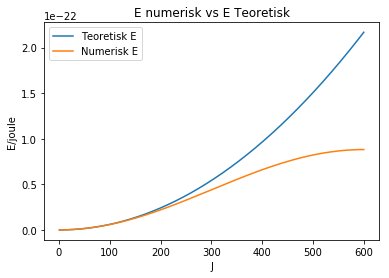

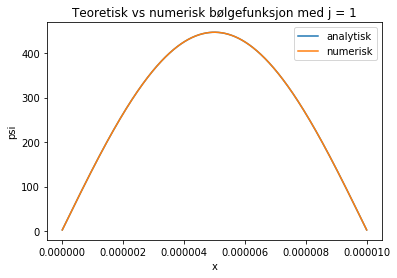

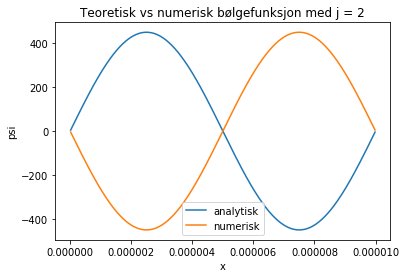

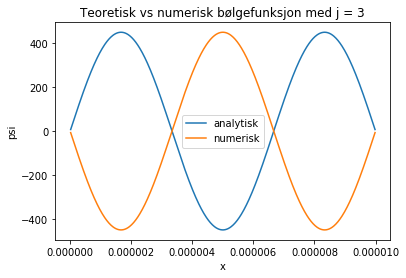

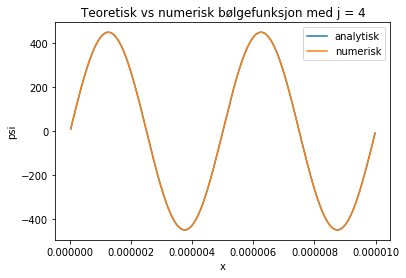

In [38]:
L = 1e-5 #intervallet, kunne ha blitt satt til 1 eller n+1
Delta = L/(n+1) # avstand mellom to påfælgende punkt.
x = np.linspace(Delta,L-Delta, n) #x - aksen, n elements-vektor, [Delta, 2Delta, ... L-Delta]

Ea = PIBE(j) # analytisk E vektor

"""
Lager diagonal-vektoren D 
"""
D = np.ones(n)*(hbar**2/(m*Delta**2)) # blir "hoved-diagonal"!
H = TUSLMatrix(D)
#print(H)
"""Ferdig med hermitiske matrisen, Løser polinomet det(H-I*E)=0"""

E, psi = np.linalg.eigh(H) #Gir eigenverdi nr. j i E[j-1] og
                          #tilhørende eigenvektorer i psi[:,j-1]

Lpsi = psi/np.sqrt(Delta) # gir psi som normeres med steglengde Delta
                          #Ikke over intervallet <0,n+1>


"""
Ok, ferdig med det. Nå må psi-eigenvektorene bli undersøkt. .

Under her er tester om psi er normal, ortagonal, et fullstendig sett og i samsvar med den analytiske.
"""
sumColumns = testNormality(psi)
print("\nDen følgende vektoren viser hva kvadratsummen av radene til psi summerer til, n = %s" % n)
print(sumColumns)
print ( "Det er lett å se at den er normal")

#Den er fin og normert. Noe annet hadde vært merkelig fordi np.linalg.eigh normerer radene.
#sumColumns = testNormality(Lpsi) #denne gir en vektor hvor alle elementene er 1/Delta.
#sumColumns *= Delta
#print(sumColumns) #printer her også vektoren "np.ones(n)".
"""
ortagonal = testOrtonormality(psi)
print("\nUnder er ortagonalitetsmatrise. \nHvis den ca er en (%sx%s) identitetsmatrise, er psi'ene ortonormale,\nn = %s" % (n,n,n))

print(ortagonal)
print ( "det er mulig å se at den er ortonormal")

fullSett = testFullstendigSet(psi)
print("\nUnder er Fullstendighetsmatrise. Hvis den ca er en (%sx%s) identitetsmatrise,\n danner psi'ene et fullstendig sett,\n n = %s" % (n,n,n))

print(fullSett)
print ( "det er mulig å se at den danner et fullstending sett")
"""


"""Plotter noen eksemplarer"""

addPlot(j,Ea,"Teoretisk E") # plotter teoretiske E på y-akse, og tilhørende j verdier på x-aksen
plot(j,E,"E numerisk vs E Teoretisk","Numerisk E","J","E/joule") #plotter numerisk E på lik måte


for k in range(1,5): #plotter dette 4 ganger, med forskjellig egenverdi.
    addPlot(x,PIB(x,k),"analytisk") #plotter analytisk bølgefunksjon på L
    plot(x,Lpsi[:,(k-1)], "Teoretisk vs numerisk bølgefunksjon med j = %s" % k, "numerisk","x","psi")
    #numerisk bølgefunksjon på L.

## Oppgave 2  

I denne oppgaven regnes det på en enkel modell av atomet. Atomet er endimensjonalt, med en potensialbrønn med dybde $V_0$ og bredde $w$. På hver side at atomet er det også en avstand på minst $10w$.



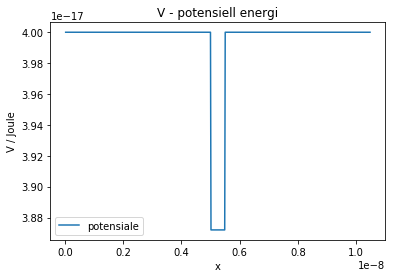

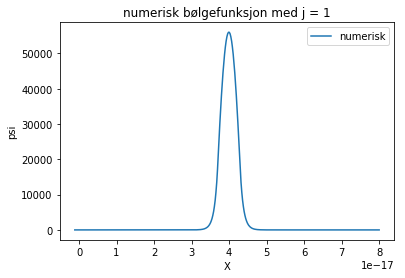

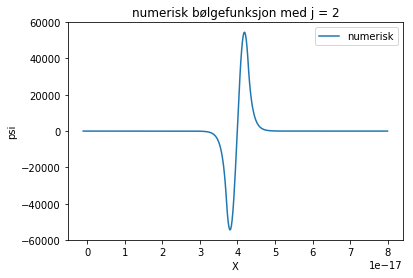

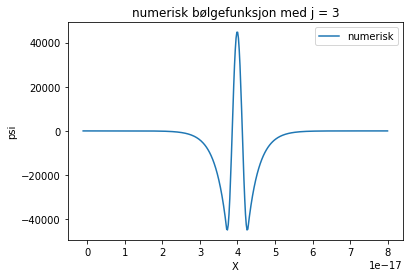

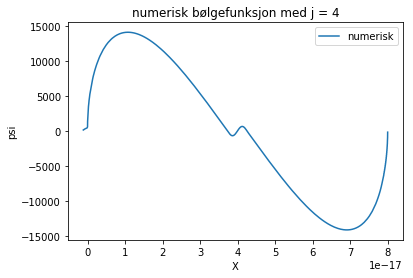

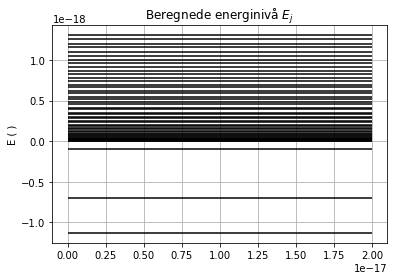

E(1) = -1.1288549697404039e-18
Avvik fra analytisk beregnet E = 1.2073748303784673 

E(2) = -6.957298116818608e-19
Avvik fra analytisk beregnet E = 2.8620537776480264 

E(3) = -9.529357394273068e-20
Avvik fra analytisk beregnet E = 0.9266429545732737 



In [81]:
"""Definerer noen nyttige variabler på nytt"""
L = w + 2*s*w #Dette gjør at det er 15w på begge sider av brønnen.
Delta = L/(n+1) #Avstand mellom to påfølgende x-verdier.
Hnn = hbar**2/(m*Delta**2) #Veriden som brukes til å regne ut diagonalen til
                           #H-matrisen
x = np.linspace(Delta,L-Delta,n) #liste med x-verdiene nevnt over

"""Lager "diagonal"-vektor D, som fanger opp formen på potensialfeltet"""
D = np.zeros(n) # (1xn) vektor med fylt med bare 0.
for k in range(0,n):
    avstand = np.absolute((k+1)*Delta-L/2) # absolutt avstand fra midten
    if avstand < (w/2.): #Innenfor atomet
        D[k] = Hnn + V_0
    else:
        D[k] = Hnn
        
"""Hvis du vil se hvordan V ser ut"""        
plot(x,D,"V - potensiell energi","potensiale","x","V / Joule")
#print(D)

"""Lager den tridiagonale Matrisen H"""
H = TUSLMatrix(D)
#print(H)

"""Løser det(H-E)=0"""
E,psi = np.linalg.eigh(H) #Gir eigenverdi nr. j, i E[j-1] og
                          #tilsvarende eigenvektorer i psi[:,j-1]

"""Skalerer det ned til å passe inn i intervallet L"""
Lpsi = psi/np.sqrt(Delta) # gir psi som normeres over L og ikke
                          #i intervallet<0,n+1>

"""Plotter noen eksemplarer"""


for k in range(1,5): #plotter dette 4 ganger, med forskjellig egenverdi.
    #addPlot(x,PIB(x,k), label="analytisk")
    plot(E, Lpsi[:,k-1],"numerisk bølgefunksjon med j = %s" % k, "numerisk","X","psi")
    

plt.hlines(E[0:50], 0, xmax=2.0e-17)
plt.grid(1, "both","both")
plt.ylabel("E ( )")
plt.title("Beregnede energinivå $E_j$")
plt.show()

#print(" E(1) = ", E[0], "\n", "E(2) = ", E[1], "\n", "E(3) = ", E[2], "\n")

for i in range(3):
    print("E(%s) = %s" %(i+1,E[i]))
    deltaES =  np.abs(tan(L*np.sqrt(2*m*np.abs(E[i]-V_0))/(2*hbar)) - np.sqrt(abs(E[i]/(E[i]-V_0))))
    deltaEAS = np.abs(tan(L*np.sqrt(2*m*np.abs(E[i]-V_0))/(2*hbar)) + np.sqrt(abs((E[i]-V_0)/E[i])))
    if ((i+1)%2):
        print("Avvik fra analytisk beregnet E = %s" %deltaES, "\n")
    else:
        print("Avvik fra analytisk beregnet E = %s" %deltaEAS, "\n")
    



For å sammenligne de beregnede energinivåene $E_j$ med analytiske løsninger benytter vi formelen

\begin{align}
\tan{\bigg(\sqrt{\frac{8mE_jL^2}{\hbar^2}}\bigg)} &= \Bigg{\{} \begin{matrix}
            \sqrt{\big|\frac{E_j}{E_j-V_0}\big|} \\
            -\sqrt{\big|\frac{E_j-V_0}{E_j}\big|}
        \end{matrix} 
\end{align}

til å teste verider for $E_j$. Ved innsetting av $E_{\{1,2,3\}}$ ser vi at 






# Mer må gjøres på oppgave 2


## Oppgave 3

I denne oppgaven blir det sett på situasjonen hvor det plasseres to atomer ved siden av hverandre. Informasjonen er som i oppgave to, bare at nå er det to brønner i midten, adskilt med en avstand b.

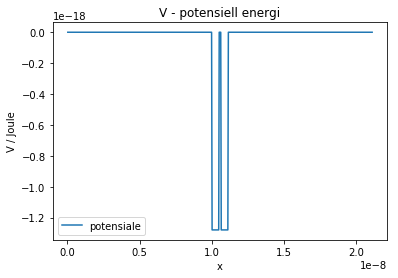

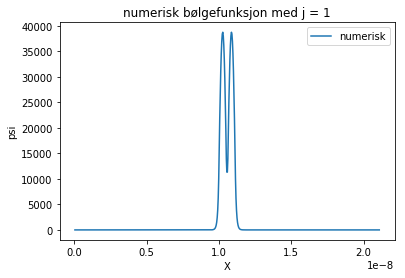

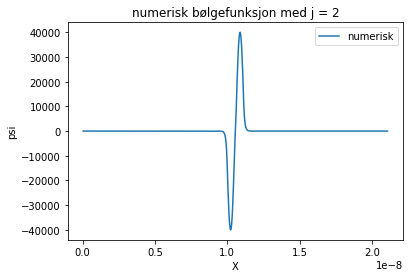

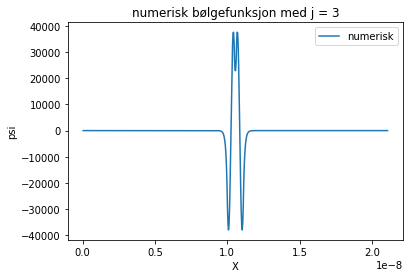

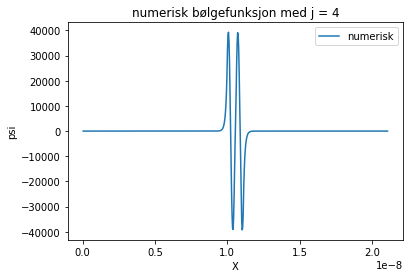

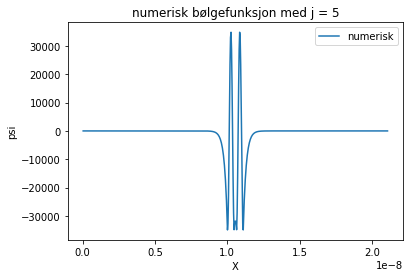

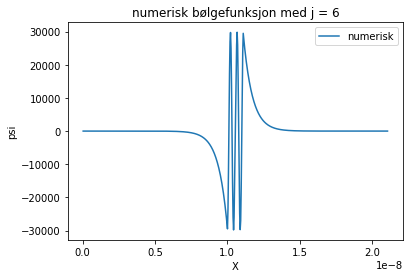

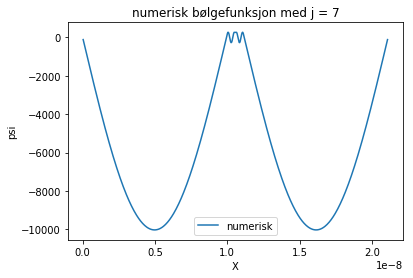

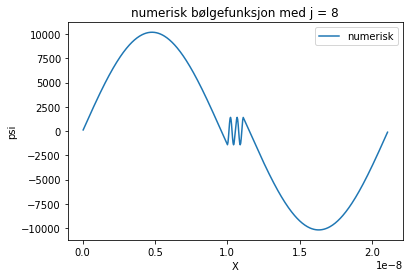

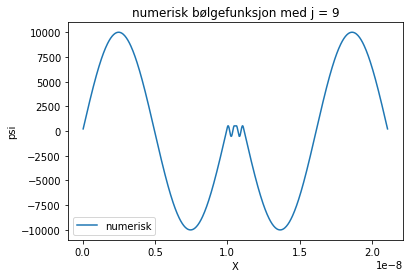

In [40]:
"""Definerer mange av de samme nyttigee variabler"""

molekyl = 2*w + (2-1)*b #lengden til molekylet
L = molekyl + 2*s*w #Dette gjør at det er 2sw på begge sider av molekylet
Delta = L/(n+1) #Avstanden mellom to påfølgende x-verdier
Hnn = hbar**2/(m*Delta**2) #Det som brukes for å regne på diagonalen til H-matrisen
x = np.linspace(Delta,L-Delta,n) #vektor med alle x-verdier

"""Lager "diagonal"-vektor D, som fanger opp formen til potensialfeltet"""
D = np.zeros(n)
for k in range(0,n):
    avstand = np.absolute((k+1)*Delta-L/2) # avstanden fra sentrum i L
    if avstand > (molekyl)/2.: #hvis utenfor molekylet
        D[k] = Hnn
    elif (avstand < b/2.): #hvis mellom atomene
        D[k] = Hnn
    else:
        D[k] = Hnn + V_0
"""Hvis du vil se hvordan V ser ut"""        
plot(x,D-Hnn,"V - potensiell energi","potensiale","x","V / Joule")
#print(D)

"""Lager den tridiagonale Matrisen H"""
H = TUSLMatrix(D)
#print(H)

"""Løser det(H-E)=0"""
E,psi = np.linalg.eigh(H) #Gir eigenverdi nr. j, i E[j-1] og
                          #tilsvarende eigenvektorer i psi[:,j-1]

"""Skalerer det ned til å passe inn i intervallet L"""
Lpsi = psi/np.sqrt(Delta) # gir psi som normeres over L og ikke
                          #i intervallet<0,n+1>

"""Plotter noen eksemplarer"""

for k in range(1,10): #plotter dette mange ganger, med forskjellig egenverdi.
    #addPlot(x,PIB(x,k), label="analytisk")
    plot(x, Lpsi[:,k-1],"numerisk bølgefunksjon med j = %s" % k, "numerisk","X","psi")

# Mer må gjøres på oppgave 3

## oppgave 4
Nå skal det regnes på en enkel model av en krystall. Det skal være $N_w$ atomer, hver med bredde $b$, og potensiale $V_0$. Igjen er det minst $10w$ til de faste veggene på hver side.

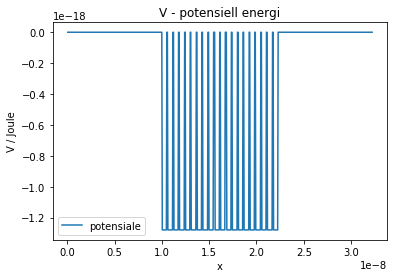

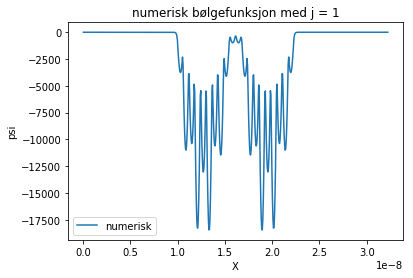

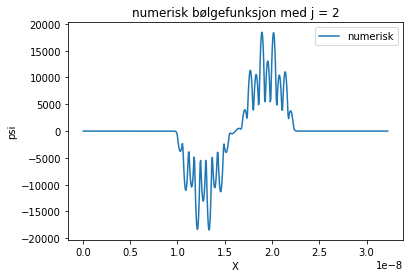

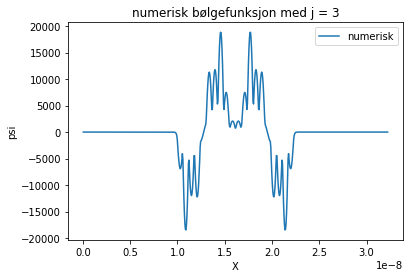

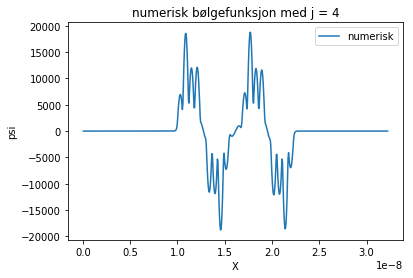

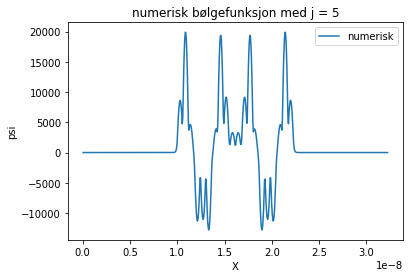

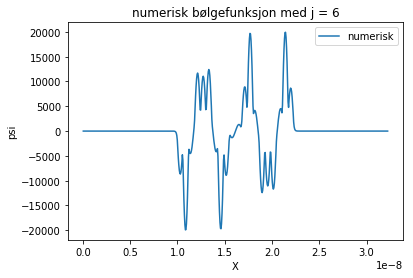

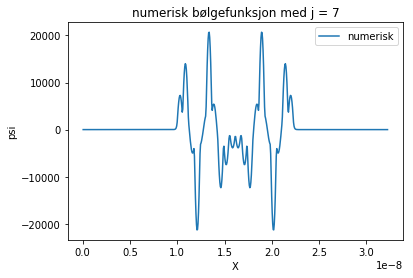

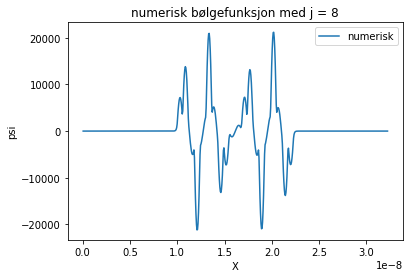

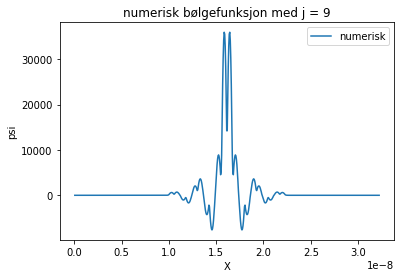

In [41]:
"""Definerer mange av de samme nyttigee variabler"""

krystall = Nw*w + (Nw-1)*b # Nw krystaller og Nw-1 områder i mellom
L = Nw*w + 2*s*w + (Nw-1)*b #Dette gjør at det er 2sw avstand utenfor krystallen og området med fast vegg.
Delta = L/(n+1) #avstanden mellom to påfølgende x-verdier.
Hnn = hbar**2/(m*Delta**2) #Verdien som brukes for å regne ut diagonalen til H-matrisen
x = np.linspace(Delta,L-Delta,n) #Liste over mulige x-verider

"""Lager "diagonal"-vektor D, som fanger opp formen til potensialfeltet"""
D = np.zeros(n) #n - nuller
for k in range(0,n):
    avstand = ((k+1)*Delta)
    if np.absolute(avstand-L/2) > (krystall)/2.: #hvis utenfor krystallen gjør
        D[k] = Hnn
    else:
        #Vi går fra venstre til høyre på tallinjen. Vi støter først på en brønn, deretter mellomrom b.
        #Dette gjentar seg. Vi definerer en gitterkonstant, deretter bruker vi, %, modulus regning
        #til å få et tall mellom 0 og gitterkonstanten. 
        #Er dette tallet mindre enn w er vi i et atom/brønn, hvis ikke er vi i mellom atomer.
        
        iKrystall = avstand - s*w # andel gått I Krystall. Vi tar vekk området til venstre for krystallen
        
        hvorICelle = iKrystall % gitterkonstant #hvor i en gittercelle vi er
        
        
        #Resten er greit.
        if hvorICelle < w:
            D[k] = Hnn + V_0
        else:
            D[k] = Hnn
    

"""Hvis du vil se hvordan V ser ut"""        
plot(x,D-Hnn,"V - potensiell energi","potensiale","x","V / Joule")
#print(D)

"""Lager den tridiagonale Matrisen H"""
H = TUSLMatrix(D)
#print(H)

"""Løser det(H-E)=0"""
E,psi = np.linalg.eigh(H) #Gir eigenverdi nr. j, i E[j-1] og
                          #tilsvarende eigenvektorer i psi[:,j-1]

"""Skalerer det ned til å passe inn i intervallet L"""
Lpsi = psi/np.sqrt(Delta) # gir psi som normeres over L og ikke
                          #i intervallet<0,n+1>

"""Plotter noen eksemplarer"""

for k in range(1,10): #plotter dette mange ganger, med forskjellig egenverdi.
    #addPlot(x,PIB(x,k), label="analytisk") #kan legge denne på
    plot(x, Lpsi[:,k-1],"numerisk bølgefunksjon med j = %s" % k, "numerisk","X","psi")

## Oppgave 5
Vi skal se på tidsutvikling av en bølgepakke.